In [2]:
import os
import numpy as np
import pandas as pd
import time
import glob
import pathlib
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
from plotnine import *
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, mean_squared_error

import sys
sys.path.append("/tf/vggish")

import vggish_params 
import vggish_input
import mel_features

seed = 27
tf.random.set_seed(seed)
random.seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [3]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [4]:
EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 200

BATCH_SIZE=32
DROPOUT=0.3
LEARNING_RATE=0.001
CLASSIFICATION_RATIO=0.999

In [6]:
data_path = '/tf/data/dementia/0extra/ADReSS-IS2020-data/train'

filenames = tf.random.shuffle(tf.io.gfile.glob(data_path + '/Full_wave_enhanced_audio/*/*'))

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [7]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))
meta.ID = meta.ID.str.strip()
meta.Gender = meta.Gender.str.strip()

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
size_sec = 30
stride_sec = 1

In [14]:
def window(x, size, stride):
    length = int(len(x))
    if length // size == 0:
        zero_padding =  tf.zeros([size] - tf.shape(x), dtype=tf.float32)
        x = tf.cast(x, tf.float32)
        x = tf.concat([x, zero_padding], 0)
        length = int(len(x))
    return tf.map_fn(lambda i: x[i*stride:i*stride+size], tf.range((length-size)//stride+1), dtype=tf.float32)

def get_data(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0]
    mmse = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0]) /30
    group = tf.gather(meta.Group.map({'cc': 0, 'cd': 1}), tf.where(tf.equal(names, name))[0][0])
    
    age = tf.gather(meta.Age, tf.where(tf.equal(names, name))[0][0])
    gender = tf.gather(meta.Gender.map({'male': 0, 'female': 1}), tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
#     waveform = decode_audio(audio_binary)
        
    rolling_waveform_tensors = window(waveform, size=int(_*size_sec), stride=int(_*stride_sec))
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
        
    return rolling_spectrograms, age, gender, mmse, group

In [15]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_data, num_parallel_calls=AUTOTUNE)\
                        .cache()\
                        .prefetch(100)\
                        .flat_map(lambda spec, age, gender, mmse, group: tf.data.Dataset.zip((
                                    tf.data.Dataset.zip((
                                        tf.data.Dataset.from_tensor_slices(spec), 
                                        tf.data.Dataset.from_tensor_slices([age]),
                                        tf.data.Dataset.from_tensor_slices([gender]),
                                    )),
                                    tf.data.Dataset.zip((
                                        tf.data.Dataset.from_tensor_slices([mmse]), 
                                        tf.data.Dataset.from_tensor_slices([group]) 
                                    ))
                                )))\
                        .shuffle(100)
    return output_ds

In [16]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [17]:
for input, output in train_ds.take(1):
    input_shape = input[0].shape
    print(input_shape)
    print(input[1])
    print(input[2])
    print(output[0])
    print(output[1])


(30, 257, 1)
tf.Tensor(72, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0.9333333333333333, shape=(), dtype=float64)
tf.Tensor(0, shape=(), dtype=int64)


In [18]:
train_ds_b = train_ds.batch(BATCH_SIZE)
val_ds_b = val_ds.batch(BATCH_SIZE)

In [19]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x[0]))

In [32]:
specInput = layers.Input(shape=input_shape)
reshapeSpecInput = layers.Reshape((input_shape[0],input_shape[1]))(specInput)
normSpec = norm_layer(reshapeSpecInput)

ageInput = layers.Input(shape=(1,))
genderInput = layers.Input(shape=(1,))


dense1 = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(normSpec)
dropout1 = layers.Dropout(0.25)(dense1)
lstm1 = layers.LSTM(128, activation='relu', kernel_initializer='he_normal', return_sequences=True)(dropout1)
dropout2 = layers.Dropout(0.25)(lstm1)
lstm2 = layers.LSTM(64, activation='relu', kernel_initializer='he_normal')(dropout2)
dropout3 = layers.Dropout(0.25)(lstm2)

concat = tf.keras.layers.Concatenate()([dropout3, ageInput, genderInput])

dense2 = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(concat)
dropout4 = layers.Dropout(0.25)(dense2)

mmseDense = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(dropout4)
mmse = layers.Dense(1, activation='sigmoid', name='mmse', kernel_initializer='he_normal')(mmseDense)

classificationDense = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(dropout4)
classification = layers.Dense(1, activation='sigmoid', name='classification')(classificationDense)

model = tf.keras.Model(
    inputs=[specInput, ageInput, genderInput],
    outputs=[mmse, classification],
)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 30, 257, 1)] 0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 30, 257)      0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 30, 257)      3           reshape_1[0][0]                  
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30, 256)      66048       normalization[1][0]              
____________________________________________________________________________________________

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0),
    loss = ['mse','binary_crossentropy'],
    loss_weights=[1, 0.1]
)

In [ ]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(SquareRootScheduler(lr=LEARNING_RATE))

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=EARLY_STOPPING_PATIENCE, 
    restore_best_weights=True)

history = model.fit(
    train_ds_b, 
    validation_data=val_ds_b,  
    epochs=EPOCHS,
    callbacks=[lr_callback, es_callback]
)

Epoch 1/1000
3/3 [==============================] - 3s 238ms/step - loss: 0.6500 - mmse_loss: 0.1593 - classification_loss: 4.9069 - val_loss: 0.3607 - val_mmse_loss: 0.0937 - val_classification_loss: 2.6695
Epoch 2/1000
3/3 [==============================] - 0s 86ms/step - loss: 0.4541 - mmse_loss: 0.1817 - classification_loss: 2.7237 - val_loss: 0.3094 - val_mmse_loss: 0.0807 - val_classification_loss: 2.2862
Epoch 3/1000
3/3 [==============================] - 0s 83ms/step - loss: 0.5055 - mmse_loss: 0.1852 - classification_loss: 3.2028 - val_loss: 0.4633 - val_mmse_loss: 0.1700 - val_classification_loss: 2.9327
Epoch 4/1000
3/3 [==============================] - 0s 84ms/step - loss: 0.7201 - mmse_loss: 0.2029 - classification_loss: 5.1712 - val_loss: 0.4535 - val_mmse_loss: 0.1963 - val_classification_loss: 2.5727
Epoch 5/1000
3/3 [==============================] - 0s 83ms/step - loss: 0.8927 - mmse_loss: 0.2550 - classification_loss: 6.3774 - val_loss: 0.4008 - val_mmse_loss: 0.189

3/3 [==============================] - 0s 86ms/step - loss: 0.4080 - mmse_loss: 0.1522 - classification_loss: 2.5586 - val_loss: 0.1897 - val_mmse_loss: 0.0937 - val_classification_loss: 0.9597
Epoch 41/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.3710 - mmse_loss: 0.1498 - classification_loss: 2.2122 - val_loss: 0.1750 - val_mmse_loss: 0.0937 - val_classification_loss: 0.8122
Epoch 42/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.3394 - mmse_loss: 0.1440 - classification_loss: 1.9533 - val_loss: 0.1673 - val_mmse_loss: 0.0937 - val_classification_loss: 0.7352
Epoch 43/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.3265 - mmse_loss: 0.1449 - classification_loss: 1.8160 - val_loss: 0.1913 - val_mmse_loss: 0.0937 - val_classification_loss: 0.9756
Epoch 44/1000
3/3 [==============================] - 0s 89ms/step - loss: 0.3861 - mmse_loss: 0.1664 - classification_loss: 2.1969 - val_loss: 0.2101 - val_mmse_loss: 0.0937 - val_cl

3/3 [==============================] - 0s 91ms/step - loss: 0.2341 - mmse_loss: 0.1236 - classification_loss: 1.1046 - val_loss: 0.1687 - val_mmse_loss: 0.0938 - val_classification_loss: 0.7496
Epoch 80/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.2690 - mmse_loss: 0.1355 - classification_loss: 1.3345 - val_loss: 0.1661 - val_mmse_loss: 0.0938 - val_classification_loss: 0.7236
Epoch 81/1000
3/3 [==============================] - 0s 87ms/step - loss: 0.2462 - mmse_loss: 0.1293 - classification_loss: 1.1696 - val_loss: 0.1656 - val_mmse_loss: 0.0938 - val_classification_loss: 0.7189
Epoch 82/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.2604 - mmse_loss: 0.1175 - classification_loss: 1.4291 - val_loss: 0.1661 - val_mmse_loss: 0.0938 - val_classification_loss: 0.7235
Epoch 83/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.2257 - mmse_loss: 0.1191 - classification_loss: 1.0662 - val_loss: 0.1640 - val_mmse_loss: 0.0938 - val_cl

3/3 [==============================] - 0s 89ms/step - loss: 0.2168 - mmse_loss: 0.1235 - classification_loss: 0.9327 - val_loss: 0.1517 - val_mmse_loss: 0.0938 - val_classification_loss: 0.5795
Epoch 119/1000
3/3 [==============================] - 0s 89ms/step - loss: 0.2250 - mmse_loss: 0.1260 - classification_loss: 0.9900 - val_loss: 0.1507 - val_mmse_loss: 0.0938 - val_classification_loss: 0.5692
Epoch 120/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.2257 - mmse_loss: 0.1160 - classification_loss: 1.0972 - val_loss: 0.1511 - val_mmse_loss: 0.0938 - val_classification_loss: 0.5739
Epoch 121/1000
3/3 [==============================] - 0s 87ms/step - loss: 0.2308 - mmse_loss: 0.1116 - classification_loss: 1.1918 - val_loss: 0.1515 - val_mmse_loss: 0.0938 - val_classification_loss: 0.5774
Epoch 122/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.2274 - mmse_loss: 0.1181 - classification_loss: 1.0928 - val_loss: 0.1513 - val_mmse_loss: 0.0937 - va

3/3 [==============================] - 0s 88ms/step - loss: 0.2157 - mmse_loss: 0.1202 - classification_loss: 0.9555 - val_loss: 0.1419 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4816
Epoch 158/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.2216 - mmse_loss: 0.1058 - classification_loss: 1.1580 - val_loss: 0.1415 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4774
Epoch 159/1000
3/3 [==============================] - 0s 87ms/step - loss: 0.1896 - mmse_loss: 0.1226 - classification_loss: 0.6708 - val_loss: 0.1407 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4691
Epoch 160/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.2176 - mmse_loss: 0.1176 - classification_loss: 1.0000 - val_loss: 0.1396 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4588
Epoch 161/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.2247 - mmse_loss: 0.1320 - classification_loss: 0.9268 - val_loss: 0.1393 - val_mmse_loss: 0.0937 - va

3/3 [==============================] - 0s 88ms/step - loss: 0.1872 - mmse_loss: 0.1178 - classification_loss: 0.6940 - val_loss: 0.1439 - val_mmse_loss: 0.0937 - val_classification_loss: 0.5015
Epoch 197/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.1922 - mmse_loss: 0.1236 - classification_loss: 0.6858 - val_loss: 0.1455 - val_mmse_loss: 0.0937 - val_classification_loss: 0.5175
Epoch 198/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.1801 - mmse_loss: 0.1222 - classification_loss: 0.5784 - val_loss: 0.1464 - val_mmse_loss: 0.0937 - val_classification_loss: 0.5264
Epoch 199/1000
3/3 [==============================] - 0s 159ms/step - loss: 0.1905 - mmse_loss: 0.1199 - classification_loss: 0.7066 - val_loss: 0.1454 - val_mmse_loss: 0.0937 - val_classification_loss: 0.5168
Epoch 200/1000
3/3 [==============================] - 0s 93ms/step - loss: 0.2178 - mmse_loss: 0.1305 - classification_loss: 0.8732 - val_loss: 0.1446 - val_mmse_loss: 0.0937 - v

3/3 [==============================] - 0s 89ms/step - loss: 0.1728 - mmse_loss: 0.1119 - classification_loss: 0.6089 - val_loss: 0.1378 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4402
Epoch 236/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.1567 - mmse_loss: 0.0977 - classification_loss: 0.5901 - val_loss: 0.1376 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4381
Epoch 237/1000
3/3 [==============================] - 0s 156ms/step - loss: 0.2256 - mmse_loss: 0.1434 - classification_loss: 0.8226 - val_loss: 0.1379 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4417
Epoch 238/1000
3/3 [==============================] - 0s 89ms/step - loss: 0.1801 - mmse_loss: 0.1143 - classification_loss: 0.6577 - val_loss: 0.1383 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4453
Epoch 239/1000
3/3 [==============================] - 0s 87ms/step - loss: 0.2006 - mmse_loss: 0.1122 - classification_loss: 0.8838 - val_loss: 0.1387 - val_mmse_loss: 0.0937 - v

3/3 [==============================] - 0s 159ms/step - loss: 0.2016 - mmse_loss: 0.1200 - classification_loss: 0.8169 - val_loss: 0.1410 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4727
Epoch 275/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.1819 - mmse_loss: 0.1065 - classification_loss: 0.7539 - val_loss: 0.1409 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4717
Epoch 276/1000
3/3 [==============================] - 0s 89ms/step - loss: 0.1940 - mmse_loss: 0.1201 - classification_loss: 0.7390 - val_loss: 0.1407 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4696
Epoch 277/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.1949 - mmse_loss: 0.1133 - classification_loss: 0.8164 - val_loss: 0.1419 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4813
Epoch 278/1000
3/3 [==============================] - 0s 91ms/step - loss: 0.1776 - mmse_loss: 0.1147 - classification_loss: 0.6298 - val_loss: 0.1462 - val_mmse_loss: 0.0937 - v

3/3 [==============================] - 0s 86ms/step - loss: 0.1718 - mmse_loss: 0.1084 - classification_loss: 0.6341 - val_loss: 0.1443 - val_mmse_loss: 0.0937 - val_classification_loss: 0.5059
Epoch 314/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.1918 - mmse_loss: 0.1218 - classification_loss: 0.7000 - val_loss: 0.1443 - val_mmse_loss: 0.0937 - val_classification_loss: 0.5057
Epoch 315/1000
3/3 [==============================] - 0s 87ms/step - loss: 0.1880 - mmse_loss: 0.1173 - classification_loss: 0.7074 - val_loss: 0.1445 - val_mmse_loss: 0.0937 - val_classification_loss: 0.5073
Epoch 316/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.1948 - mmse_loss: 0.1326 - classification_loss: 0.6223 - val_loss: 0.1446 - val_mmse_loss: 0.0937 - val_classification_loss: 0.5081
Epoch 317/1000
3/3 [==============================] - 0s 89ms/step - loss: 0.1844 - mmse_loss: 0.1155 - classification_loss: 0.6898 - val_loss: 0.1453 - val_mmse_loss: 0.0937 - va

3/3 [==============================] - 0s 90ms/step - loss: 0.2078 - mmse_loss: 0.1243 - classification_loss: 0.8348 - val_loss: 0.1409 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4717
Epoch 353/1000
3/3 [==============================] - 0s 86ms/step - loss: 0.2019 - mmse_loss: 0.1367 - classification_loss: 0.6522 - val_loss: 0.1404 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4669
Epoch 354/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.1667 - mmse_loss: 0.1180 - classification_loss: 0.4878 - val_loss: 0.1394 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4568
Epoch 355/1000
3/3 [==============================] - 0s 87ms/step - loss: 0.1873 - mmse_loss: 0.0991 - classification_loss: 0.8822 - val_loss: 0.1387 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4497
Epoch 356/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.1640 - mmse_loss: 0.1064 - classification_loss: 0.5754 - val_loss: 0.1398 - val_mmse_loss: 0.0937 - va

3/3 [==============================] - 0s 90ms/step - loss: 0.1748 - mmse_loss: 0.1174 - classification_loss: 0.5738 - val_loss: 0.1445 - val_mmse_loss: 0.0937 - val_classification_loss: 0.5074
Epoch 392/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.1773 - mmse_loss: 0.1123 - classification_loss: 0.6498 - val_loss: 0.1434 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4968
Epoch 393/1000
3/3 [==============================] - 0s 89ms/step - loss: 0.1821 - mmse_loss: 0.1119 - classification_loss: 0.7013 - val_loss: 0.1422 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4842
Epoch 394/1000
3/3 [==============================] - 0s 91ms/step - loss: 0.1548 - mmse_loss: 0.1048 - classification_loss: 0.4997 - val_loss: 0.1418 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4806
Epoch 395/1000
3/3 [==============================] - 0s 89ms/step - loss: 0.1809 - mmse_loss: 0.1191 - classification_loss: 0.6175 - val_loss: 0.1421 - val_mmse_loss: 0.0937 - va

3/3 [==============================] - 0s 89ms/step - loss: 0.1728 - mmse_loss: 0.1137 - classification_loss: 0.5910 - val_loss: 0.1415 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4776
Epoch 431/1000
3/3 [==============================] - 0s 87ms/step - loss: 0.1693 - mmse_loss: 0.1116 - classification_loss: 0.5764 - val_loss: 0.1422 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4848
Epoch 432/1000
3/3 [==============================] - 0s 91ms/step - loss: 0.1525 - mmse_loss: 0.0972 - classification_loss: 0.5537 - val_loss: 0.1412 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4744
Epoch 433/1000
3/3 [==============================] - 0s 87ms/step - loss: 0.1672 - mmse_loss: 0.1166 - classification_loss: 0.5060 - val_loss: 0.1385 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4475
Epoch 434/1000
3/3 [==============================] - 0s 86ms/step - loss: 0.1643 - mmse_loss: 0.1195 - classification_loss: 0.4478 - val_loss: 0.1384 - val_mmse_loss: 0.0935 - va

3/3 [==============================] - 0s 88ms/step - loss: 0.1499 - mmse_loss: 0.0970 - classification_loss: 0.5294 - val_loss: 0.1433 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4958
Epoch 470/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.1562 - mmse_loss: 0.0951 - classification_loss: 0.6112 - val_loss: 0.1462 - val_mmse_loss: 0.0937 - val_classification_loss: 0.5242
Epoch 471/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.1450 - mmse_loss: 0.0899 - classification_loss: 0.5511 - val_loss: 0.1471 - val_mmse_loss: 0.0937 - val_classification_loss: 0.5338
Epoch 472/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.1823 - mmse_loss: 0.1210 - classification_loss: 0.6128 - val_loss: 0.1472 - val_mmse_loss: 0.0937 - val_classification_loss: 0.5348
Epoch 473/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.1410 - mmse_loss: 0.0968 - classification_loss: 0.4421 - val_loss: 0.1466 - val_mmse_loss: 0.0937 - va

3/3 [==============================] - 0s 92ms/step - loss: 0.1506 - mmse_loss: 0.1052 - classification_loss: 0.4532 - val_loss: 0.1422 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4851
Epoch 509/1000
3/3 [==============================] - 0s 87ms/step - loss: 0.1963 - mmse_loss: 0.1270 - classification_loss: 0.6926 - val_loss: 0.1408 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4707
Epoch 510/1000
3/3 [==============================] - 0s 91ms/step - loss: 0.1482 - mmse_loss: 0.1046 - classification_loss: 0.4359 - val_loss: 0.1408 - val_mmse_loss: 0.0936 - val_classification_loss: 0.4716
Epoch 511/1000
3/3 [==============================] - 0s 89ms/step - loss: 0.1556 - mmse_loss: 0.1018 - classification_loss: 0.5379 - val_loss: 0.1423 - val_mmse_loss: 0.0935 - val_classification_loss: 0.4878
Epoch 512/1000
3/3 [==============================] - 0s 89ms/step - loss: 0.2364 - mmse_loss: 0.1528 - classification_loss: 0.8359 - val_loss: 0.1423 - val_mmse_loss: 0.0936 - va

3/3 [==============================] - 0s 90ms/step - loss: 0.1479 - mmse_loss: 0.1014 - classification_loss: 0.4646 - val_loss: 0.1361 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4240
Epoch 548/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.1445 - mmse_loss: 0.0880 - classification_loss: 0.5644 - val_loss: 0.1360 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4223
Epoch 549/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.1605 - mmse_loss: 0.1005 - classification_loss: 0.5998 - val_loss: 0.1363 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4259
Epoch 550/1000
3/3 [==============================] - 0s 91ms/step - loss: 0.1301 - mmse_loss: 0.0925 - classification_loss: 0.3755 - val_loss: 0.1369 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4317
Epoch 551/1000
3/3 [==============================] - 0s 89ms/step - loss: 0.1626 - mmse_loss: 0.1186 - classification_loss: 0.4397 - val_loss: 0.1372 - val_mmse_loss: 0.0937 - va

3/3 [==============================] - 0s 87ms/step - loss: 0.1856 - mmse_loss: 0.1221 - classification_loss: 0.6354 - val_loss: 0.1402 - val_mmse_loss: 0.0936 - val_classification_loss: 0.4658
Epoch 587/1000
3/3 [==============================] - 0s 89ms/step - loss: 0.1461 - mmse_loss: 0.1043 - classification_loss: 0.4186 - val_loss: 0.1398 - val_mmse_loss: 0.0937 - val_classification_loss: 0.4617
Epoch 588/1000


In [ ]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mmse_loss']) * 30, np.sqrt(metrics['val_mmse_loss'] )* 30)
plt.legend(['train', 'val'])
plt.show()

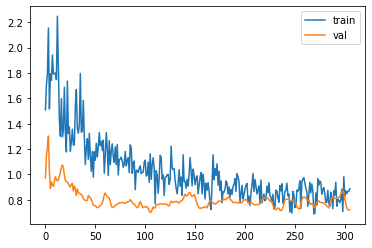

In [26]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['classification_loss']), np.sqrt(metrics['val_classification_loss']))
plt.legend(['train', 'val'])
plt.show()

In [29]:
model.predict(preprocess_dataset([train_files[2]]).batch(1))[0].flatten()[0]

1.0

In [20]:
meta = meta.assign(split = '', predict_mmse = -99.99, predict_group_prob = 0)

def applyModelStats(file, split_type):
    
    id = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    
    meta.loc[meta["ID"]==id,'split'] = split_type
    predict = model.predict(preprocess_dataset([file]).batch(1))
    
    mmse = predict[0].flatten()[0]
    group_prob = predict[1].flatten()[0]
    
    median_predict = np.percentile(predict[0].flatten()[0], 50)   
    predict25 = np.percentile(predict[0].flatten()[0], 25)   
    predict75 = np.percentile(predict[0].flatten()[0], 75)   
    
    avg_predict_group_prob = np.median(predict[1][:,0])
    std_predict_group_prob = np.std(predict[1][:,0])
    
    meta.loc[meta["ID"]==id,'predict_mmse'] = mmse    
    meta.loc[meta["ID"]==id,'predict_group_prob'] = group_prob


for file in train_files:
    applyModelStats(file, "train")
    
for file in val_files:
    applyModelStats(file, "val")
    
for file in test_files:
    applyModelStats(file, "test")

In [21]:
meta

,index,ID,Age,Gender,MMSE,Group,split,predict_mmse,predict_group_prob
0,0,S001,74,male,30,cc,train,25.081205,0.027883
1,1,S002,62,female,30,cc,train,18.293940,0.216480
2,2,S003,69,female,29,cc,train,31.432690,0.000029
3,3,S004,71,female,30,cc,test,28.395407,0.002509
4,4,S005,74,female,30,cc,val,22.318474,0.162713
...,...,...,...,...,...,...,...,...,...
103,49,S150,58,male,20,cd,train,19.098625,0.466234
104,50,S151,72,male,24,cd,train,13.419196,1.000000
105,51,S153,68,female,12,cd,val,14.659718,0.963745
106,52,S154,65,female,20,cd,train,13.369176,0.999345


In [22]:
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
def cal_rmse(g):
    rmse = np.sqrt(mean_squared_error(g['MMSE'], g['predict_mmse'] ) )
    return pd.Series(dict(rmse = rmse ))

meta.groupby('split').apply(cal_rmse).reset_index()

,split,rmse
0,test,8.838049
1,train,5.961272
2,val,8.282809


In [23]:
meta.groupby('Gender').apply(cal_rmse).reset_index()

,Gender,rmse
0,female,6.687754
1,male,7.081758


In [24]:
np.sqrt(mean_squared_error(meta['MMSE'], meta['predict_mmse'] ))

6.865658669209108

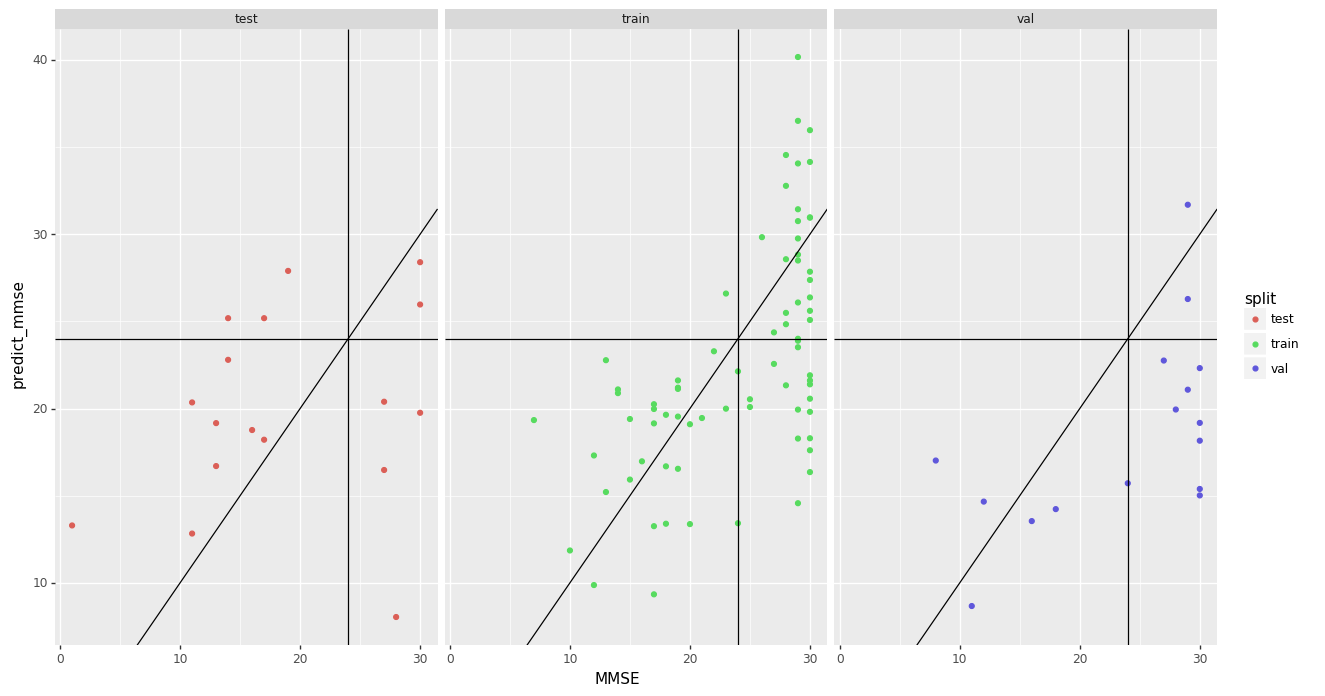

<ggplot: (8762652154039)>

In [25]:
ggplot(meta) + \
geom_point(aes(x = 'MMSE', y = 'predict_mmse', colour = 'split')) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

Logistic: ROC AUC = 0.843


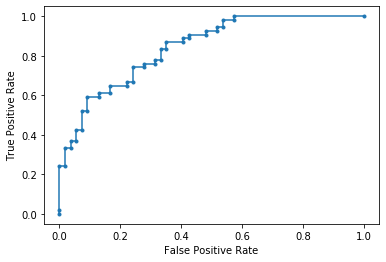

In [26]:
y = meta.Group.apply(lambda x: 1 if x=="cd" else 0)
probs = meta.predict_group_prob

lr_auc = roc_auc_score(y, probs)

# summarize scores
print('Logistic: ROC AUC = %.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the plot
plt.show()

In [27]:
# model.save('saved_model/base_line/20210222')

In [28]:
ls saved_model/base_line

20210210/  20210217/  20210222/  20210225/
